#### Before running this notebook, please make sure to run the `verification_rank_hist_compute.ipynb` notebook to generate the pickle files.

In [1]:
import sys
sys.path.append('..')

import pickle

import matplotlib.pyplot as plt
from pysteps.verification.ensscores import rankhist_compute

import numpy as np

Pysteps configuration file found at: /home/gabriele/Documents/fbk/meteo/GPTCast/.venv/lib/python3.12/site-packages/pysteps/pystepsrc



In [2]:
input_data_path = '../data/verification_fts/'
output_data_path = '../data/verification_fts/'

mod_list = [
    {
        'name': 'gptcast_16x16',
        'label': 'GPTCast-16x16',
        'color': 'blue',
        'linestyle': '-',
    },
    {
        'name': 'gptcast_8x8',
        'label': 'GPTCast-8x8',
        'color': 'blue',
        'linestyle': '--',
    },
    {
        'name': 'linda',
        'label': 'Linda (Pysteps)',
        'color': 'black',
        'linestyle': '-',
    },
]

mod_names_list = [x['name'] for x in mod_list]
mod_labels = [x['label'] for x in mod_list]
mod_colors = [x['color'] for x in mod_list]
mod_linestyles = [x['linestyle'] for x in mod_list]
fname = 'tables_verification_nc_rank_hist.pkl'

input_rankhist_fn = [f'{x}/{fname}' for x in mod_names_list]
output_rankhist_fn = 'rank_hists'

In [3]:
rankhist_tables = []
for i, fn in enumerate(input_rankhist_fn):
    # Open rankhist
    with open(input_data_path + fn, "rb") as f:
        rankhist_tables.append(pickle.load(f))
    f.close()

In [4]:
def rank_DKL(rank_dist, num_forecasts=20):
    h = rank_dist
    q = h / h.sum()
    p = 1/len(h)
    return p*np.log(p/q).sum()

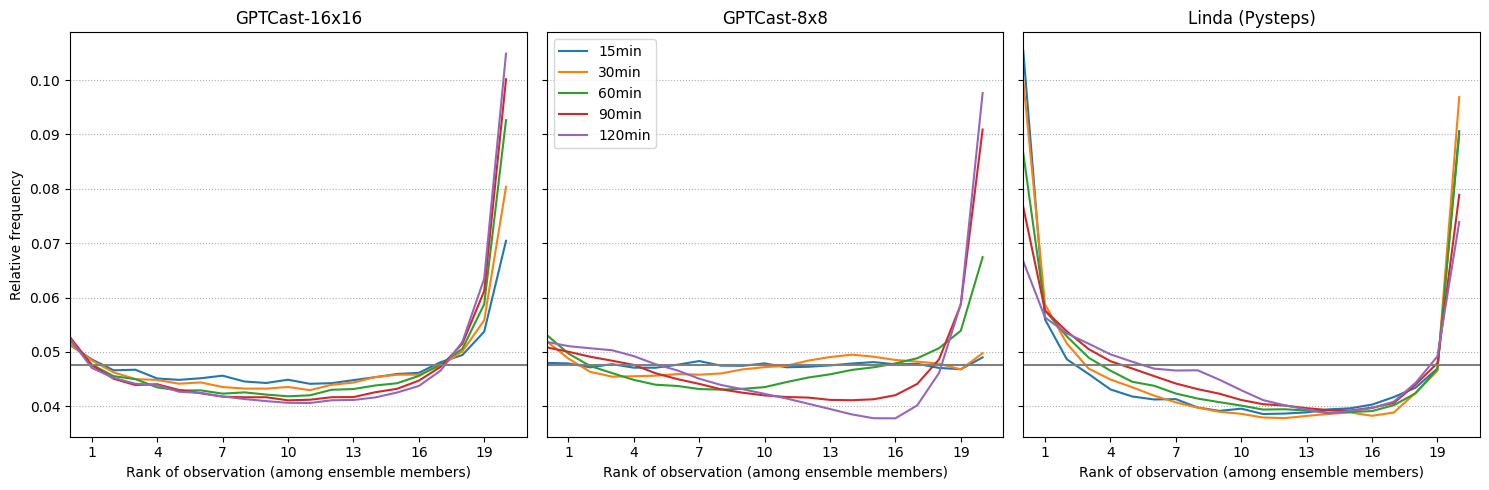

In [5]:
fig, ax = plt.subplots(1,len(mod_names_list), figsize=(15, 5), sharey=True)
# plt.suptitle(mod_names_list[idx])
for mod_idx, tables in enumerate(rankhist_tables):
    my_ax = ax[mod_idx]
    for lead_time in tables:
        if lead_time != 1000:
            rankhist = tables[lead_time]
            # print(lead_time , rankhist['n'])
            # print(lead_time )
            r = rankhist_compute(rankhist)
            lab = f"{lead_time}min"
            # raise
            x = np.linspace(0, 1, rankhist["num_ens_members"] + 1)
            my_ax.plot(x, r, label=lab)
    my_ax.set_title(mod_labels[mod_idx])
    my_ax.set_xticks(x[::3] + (x[1] - x[0]))
    my_ax.set_xticklabels(np.arange(1, len(x) + 1)[::3])
    my_ax.set_xlim(0, 1 + 1.0 / len(x))
    # my_ax.set_ylim(0, np.max(r) * 1.25)
    my_ax.set_xlabel("Rank of observation (among ensemble members)")
    my_ax.grid(True, axis="y", ls=":")
    my_ax.hlines(1/21., xmin=-10, xmax=30, colors='gray')
ax[1].legend()
ax[0].set_ylabel("Relative frequency")
fig.tight_layout()
plt.savefig(output_data_path + output_rankhist_fn + '_lead_times.png', dpi=300, bbox_inches="tight")

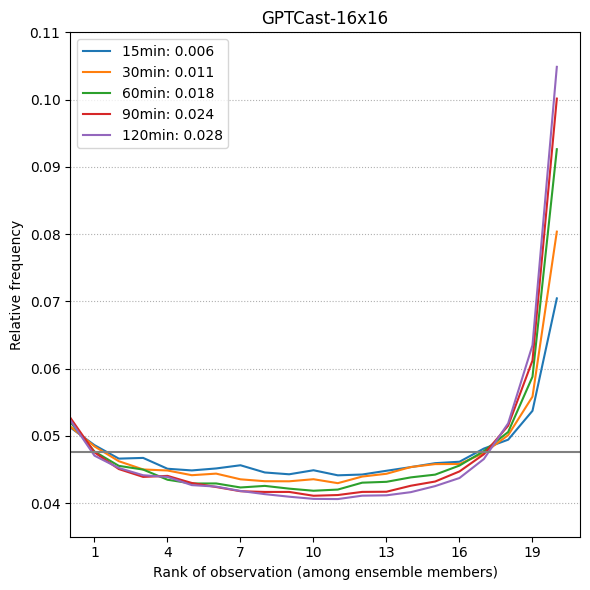

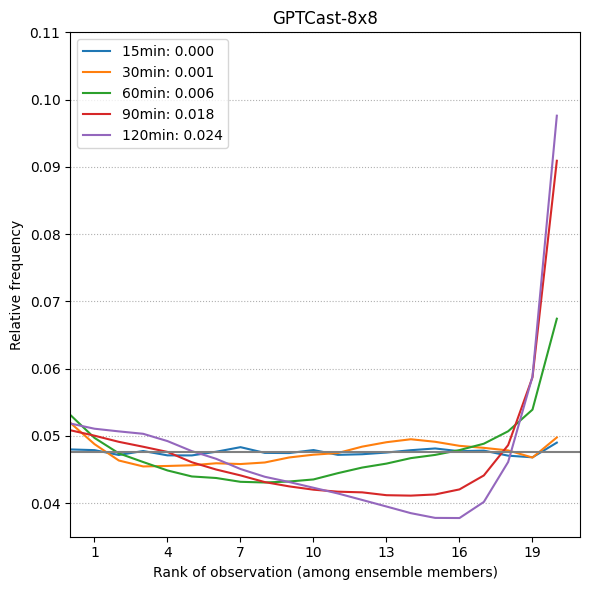

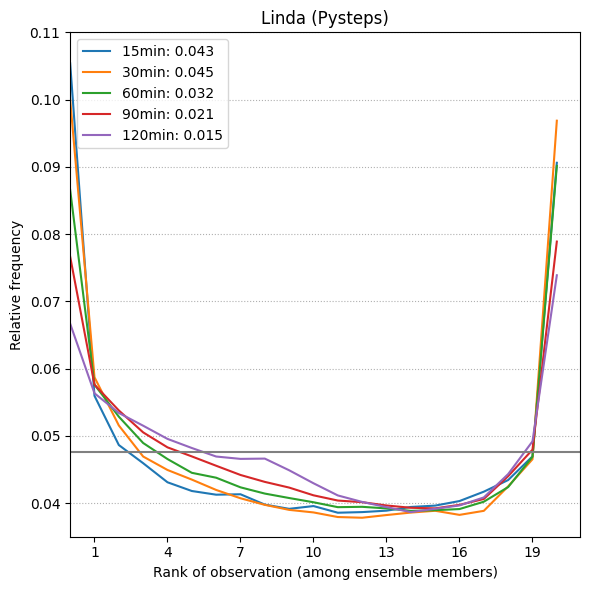

In [6]:
for mod_idx, tables in enumerate(rankhist_tables):
    fig, ax = plt.subplots(1, figsize=(6,6), sharey=True)
# plt.suptitle(mod_names_list[idx])
    my_ax = ax
    for lead_time in tables:
        if lead_time != 1000:
            rankhist = tables[lead_time]
            # print(lead_time , rankhist['n'])
            # print(lead_time )
            r = rankhist_compute(rankhist)
            kl = rank_DKL(r)
            lab = f"{lead_time}min: {kl:.3f}"
            # raise
            x = np.linspace(0, 1, rankhist["num_ens_members"] + 1)
            my_ax.plot(x, r, label=lab)
    my_ax.set_title(mod_labels[mod_idx])
    my_ax.set_xticks(x[::3] + (x[1] - x[0]))
    my_ax.set_xticklabels(np.arange(1, len(x) + 1)[::3])
    my_ax.set_xlim(0, 1 + 1.0 / len(x))
    my_ax.set_ylim(0.035, 0.11)
    my_ax.set_xlabel("Rank of observation (among ensemble members)")
    my_ax.grid(True, axis="y", ls=":")
    my_ax.hlines(1/21., xmin=-10, xmax=30, colors='gray')
    ax.legend()
    ax.set_ylabel("Relative frequency")
    fig.tight_layout()
    plt.savefig(output_data_path + output_rankhist_fn + '_' + mod_names_list[mod_idx] + '_lead_times.png', dpi=300, bbox_inches="tight")

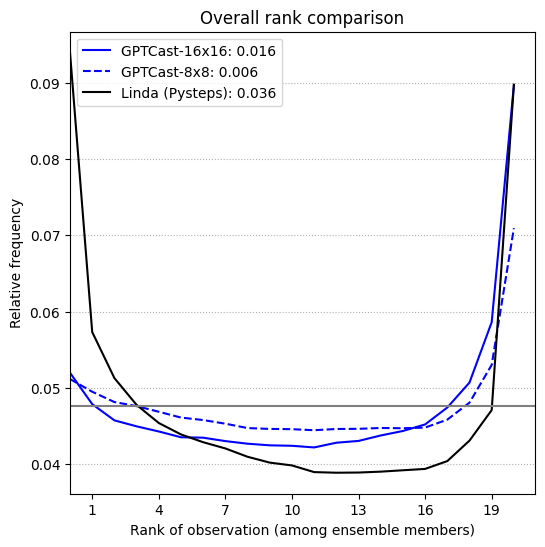

In [7]:
def compare_rankhist_models(tables, mod_names_list, output_fn, output_data_path):
    fig, ax = plt.subplots(figsize=(6, 6))
    # plt.suptitle('compare_topk')
    for mod_idx, mod_tables in enumerate(tables):
        # print(mod_tables)
        lead_time = 1000
        rankhist = mod_tables[lead_time]
        # print(rankhist)
        r = rankhist_compute(rankhist)
        kl = rank_DKL(r)
        x = np.linspace(0, 1, rankhist["num_ens_members"] + 1)
        ax.plot(x, r, label=f"{mod_labels[mod_idx]}: {kl:.3f}", color=mod_colors[mod_idx], linestyle=mod_linestyles[mod_idx])
    ax.set_title("Overall rank comparison")
    ax.set_xticks(x[::3] + (x[1] - x[0]))
    ax.set_xticklabels(np.arange(1, len(x) + 1)[::3])
    ax.set_xlim(0, 1 + 1.0 / len(x))
    # ax.set_ylim(0, np.max(r) * 1.25)
    ax.set_xlabel("Rank of observation (among ensemble members)")
    ax.set_ylabel("Relative frequency")
    ax.grid(True, axis="y", ls=":")
    ax.legend()
    ax.hlines(1/21., xmin=-10, xmax=30, colors='gray')
    plt.savefig(output_data_path + output_fn, dpi=300, bbox_inches="tight")


filename = output_rankhist_fn
compare_rankhist_models(rankhist_tables, mod_names_list, filename, output_data_path)

